# Ecological Index - table information
- Print statistics **related to polynyas**
- Notebook by Alice DuVivier (NCAR)
- Note: this notebook needs to load the utils.py file
- November 2024

In [1]:
import utils
import xarray as xr
import numpy as np
from glob import glob
import intake
import importlib
import pop_tools
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import matplotlib.ticker as mticker
import cartopy
import cartopy.crs as ccrs
import cmocean
import geopandas as gpd

### Load grid and mask data

In [2]:
# directory path
dir_in = '/glade/u/home/duvivier/masks/'

In [3]:
# load ocean grid
fin = 'ocn_grid_gx1v7.nc'
ds_grid = xr.open_mfdataset(dir_in+fin,decode_times=False)
ds_grid['nlat'] = ds_grid.nlat
ds_grid['nlon'] = ds_grid.nlon
ds_grid

<xarray.Dataset>
Dimensions:                 (moc_comp: 3, transport_comp: 5, transport_reg: 2, z_t: 60, z_t_150m: 15, z_w: 60, z_w_top: 60, z_w_bot: 60, lat_aux_grid: 395, moc_z: 61, nlat: 384, nlon: 320, time: 1188, d2: 2)
Coordinates: (12/14)
  * z_t                     (z_t) float32 500.0 1.5e+03 ... 5.125e+05 5.375e+05
  * z_t_150m                (z_t_150m) float32 500.0 1.5e+03 ... 1.45e+04
  * z_w                     (z_w) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_top                 (z_w_top) float32 0.0 1e+03 2e+03 ... 5e+05 5.25e+05
  * z_w_bot                 (z_w_bot) float32 1e+03 2e+03 ... 5.25e+05 5.5e+05
  * lat_aux_grid            (lat_aux_grid) float32 -79.49 -78.95 ... 89.47 90.0
    ...                      ...
    ULAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLONG                   (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    TLAT                    (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
  * time                    (time) float32 31.0 59.0 90.0 ... 3.61e+04 3.614e+04
  * nlat                    (nlat) int64 0 1 2 3 4 5 ... 378 379 380 381 382 383
  * nlon                    (nlon) int64 0 1 2 3 4 5 ... 314 315 316 317 318 319
Dimensions without coordinates: moc_comp, transport_comp, transport_reg, d2
Data variables: (12/58)
    moc_components          (moc_comp) |S384 dask.array<chunksize=(3,), meta=np.ndarray>
    transport_components    (transport_comp) |S384 dask.array<chunksize=(5,), meta=np.ndarray>
    transport_regions       (transport_reg) |S384 dask.array<chunksize=(2,), meta=np.ndarray>
    dz                      (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    dzw                     (z_w) float32 dask.array<chunksize=(60,), meta=np.ndarray>
    KMT                     (nlat, nlon) float64 dask.array<chunksize=(384, 320), meta=np.ndarray>
    ...                      ...
    nsurface_u              float64 ...
    time_bound              (time, d2) float64 dask.array<chunksize=(1188, 2), meta=np.ndarray>
    QFLUX                   (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF                     (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    SHF_QSW                 (time, nlat, nlon) float32 dask.array<chunksize=(1188, 384, 320), meta=np.ndarray>
    TEMP                    (time, z_t, nlat, nlon) float32 dask.array<chunksize=(1188, 60, 384, 320), meta=np.ndarray>
Attributes:
    title:             b.e21.B1850.f09_g17.CMIP6-piControl.001
    history:           none
    Conventions:       CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-cu...
    time_period_freq:  month_1
    model_doi_url:     https://doi.org/10.5065/D67H1H0V
    contents:          Diagnostic and Prognostic Variables
    source:            CCSM POP2, the CCSM Ocean Component
    revision:          $Id: tavg.F90 89644 2018-08-04 14:26:01Z klindsay $
    calendar:          All years have exactly  365 days.
    start_time:        This dataset was created on 2018-08-09 at 18:18:26.3
    cell_methods:      cell_methods = time: mean ==> the variable values are ...

In [4]:
## Enter the latitudes you want to keep:
lat_min = -80
lat_max = -60

In [5]:
# crop data to the latitudes we want, use given lat/lon, not specific indices
ds_grid = ds_grid.where(((ds_grid['TLAT'] <= lat_max) & (ds_grid['TLAT'] >= lat_min)), drop=True)

In [6]:
# save tarea and convert to km2
cm2_to_km2 = 100.0 * 100.0 * 1000.0 * 1000.0
tarea = ds_grid.TAREA/cm2_to_km2

## Load EcoIndex Data

In [7]:
path_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/ecoindex/'

### Load "Present Day"

In [8]:
file_in = 'ecoindex_present_day.nc'
ds_eco = xr.open_dataset(path_in+file_in, decode_times=True)

# mask land
ds_eco = ds_eco.where(ds_grid.REGION_MASK == 1)

In [9]:
# keep regional version only
eco_pd = ds_eco.ecoindex_regional_noseal

### Load model data

In [10]:
file_in = 'ecoindex_historical_future.nc'
ds_eco = xr.open_dataset(path_in+file_in, decode_times=True)

# mask land
ds_eco = ds_eco.where(ds_grid.REGION_MASK == 1)

In [11]:
# keep some decades
eco_2000 = ds_eco.ecoindex_regional_decadal.sel(decades=2000)

In [12]:
# keep some decades
eco_2090 = ds_eco.ecoindex_regional_decadal.sel(decades=2090)

## Load Typical polynya data

In [13]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/ecoindex_data/sea_ice/'

In [14]:
# Read in satellite polynya data
file_in = 'CESM_grid_SSMI_typical_polynya.nc'
ds_poly = xr.open_mfdataset(dir_in+file_in,decode_times=False)

poly_sat_pd = ds_poly.polynya_typical_all

In [15]:
# Read in jra55 polynya data
file_in = 'CESM_grid_JRA55_hindcast_typical_polynya.nc'
ds_poly = xr.open_mfdataset(dir_in+file_in,decode_times=False)

poly_jra_pd = ds_poly.polynya_typical_all_hi

In [16]:
# Read in cesm2-le polynya data
file_in = 'CESM_grid_CESM2-LE_typical_polynya.nc'
ds_poly = xr.open_mfdataset(dir_in+file_in,decode_times=False)

poly_cesm2le_pd = ds_poly.polynya_typical_all_hi

# keep some decades
poly_2000 = poly_cesm2le_pd.sel(decades=2000)
poly_2090 = poly_cesm2le_pd.sel(decades=2090)

# reassign coordinates so it'll work later
poly_2000['nlat'] = tarea.nlat
poly_2000['nlon'] = tarea.nlon

poly_2090['nlat'] = tarea.nlat
poly_2090['nlon'] = tarea.nlon

## Load map related masks for analysis

In [17]:
dir_in = '/glade/campaign/cgd/ppc/duvivier/cesm2_antarctic_polynya/mpa_analysis/DATA/'

In [18]:
# Read in CCAMLR planning domain masks
file_in = 'CCAMLR_masks/CESM_gx1v7_CCAMLR_masks_v8_10102024.nc'
ds_ccamlr= xr.open_mfdataset(dir_in+file_in,decode_times=False)
ds_ccamlr = ds_ccamlr.isel(nlat=slice(0,36))

# keep just masks of interest (MPAs, MPA planning areas, AES)
ccamlr_in = ['mpa_plan_1_mod','mpa_plan_3_4','mpa_plan_7_mod','mpa_plan_8','mpa_plan_9',
             'Ross_mpa','Weddell_mpa','Ant_Peninsula_mpa','East_Ant_mpa',
             'AES']
ccamlr_masks = ds_ccamlr[ccamlr_in]

# now load in the different masks as a new coordinate
ccamlr_masks = xr.concat([ds_ccamlr.mpa_plan_1_mod, ds_ccamlr.mpa_plan_3_4, ds_ccamlr.mpa_plan_7_mod,
                          ds_ccamlr.mpa_plan_8, ds_ccamlr.mpa_plan_9,
                          ds_ccamlr.Ross_mpa, ds_ccamlr.Weddell_mpa,
                          ds_ccamlr.Ant_Peninsula_mpa, ds_ccamlr.East_Ant_mpa,
                          ds_ccamlr.AES],
                         dim='region')
ccamlr_masks['region']=ccamlr_in


In [19]:
# make a mask of ALL mpas (adopted and proposed)

# first load the masks and fill the missing values with 0
Ross_mpa = ccamlr_masks.sel(region='Ross_mpa').fillna(0)
Wed_mpa = ccamlr_masks.sel(region='Weddell_mpa').fillna(0)
Ant_Pen_mpa = ccamlr_masks.sel(region='Ant_Peninsula_mpa').fillna(0)
East_Ant_mpa = ccamlr_masks.sel(region='East_Ant_mpa').fillna(0)

# now sum all the masks to get all mpas
mpa_all = Ross_mpa + Wed_mpa + Ant_Pen_mpa + East_Ant_mpa
mpa_all = mpa_all.where(ds_grid.REGION_MASK == 1)

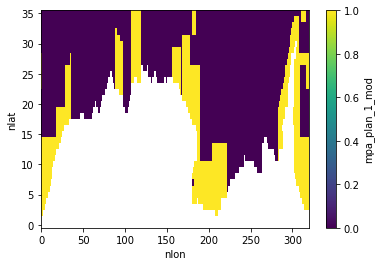

In [20]:
mpa_all.plot()

# Calculate statistics for Polynyas

## Hemispheric
- Calculate area weighted average AEV for polynyas hemispherically

#### Inside polynyas

In [21]:
# keep points only INSIDE polynyas and multiply by tarea
aev_pd = eco_pd.where(poly_sat_pd>0) * tarea
aev_2000 = eco_2000.where(poly_2000>0) * tarea
aev_2090 = eco_2090.where(poly_2090>0) * tarea

# keep tarea in polynya areas only
tarea_pd = tarea.where(poly_sat_pd>0)
tarea_2000 = tarea.where(poly_2000>0)
tarea_2090 = tarea.where(poly_2090>0)

In [22]:
# calculate and print hemispheric area weighted average
print('Observational average AEV INSIDE polynyas hemispherically')
avg_poly_pd = aev_pd.sum(dim=['nlat','nlon'])/tarea_pd.sum(dim=['nlat','nlon'])
print(avg_poly_pd.values)

print('Model 2000s average AEV INSIDE polynyas hemispherically')
avg_poly_2000 = aev_2000.sum(dim=['nlat','nlon'])/tarea_2000.sum(dim=['nlat','nlon'])
print(avg_poly_2000.values)

print('Model 2090s average AEV INSIDE polynyas hemispherically')
avg_poly_2090 = aev_2090.sum(dim=['nlat','nlon'])/tarea_2090.sum(dim=['nlat','nlon'])
print(avg_poly_2090.values)

Observational average AEV INSIDE polynyas hemispherically
0.5925855160456699
Model 2000s average AEV INSIDE polynyas hemispherically
0.6857773498937036
Model 2090s average AEV INSIDE polynyas hemispherically
0.7105056016403578


#### Outside polynyas

In [23]:
# keep points only OUTSIDE polynyas and multiply by tarea
aev_pd = eco_pd.where(poly_sat_pd.isnull()) * tarea
aev_2000 = eco_2000.where(poly_2000.isnull()) * tarea
aev_2090 = eco_2090.where(poly_2090.isnull()) * tarea

# keep tarea in polynya areas only
tarea_pd = tarea.where(poly_sat_pd.isnull())
tarea_2000 = tarea.where(poly_2000.isnull())
tarea_2090 = tarea.where(poly_2090.isnull())

In [24]:
# calculate and print hemispheric area weighted average
print('Observational average AEV OUTSIDE polynyas hemispherically')
avg_poly_pd = aev_pd.sum(dim=['nlat','nlon'])/tarea_pd.sum(dim=['nlat','nlon'])
print(avg_poly_pd.values)

print('Model 2000s average AEV OUTSIDE polynyas hemispherically')
avg_poly_2000 = aev_2000.sum(dim=['nlat','nlon'])/tarea_2000.sum(dim=['nlat','nlon'])
print(avg_poly_2000.values)

print('Model 2090s average AEV OUTSIDE polynyas hemispherically')
avg_poly_2090 = aev_2090.sum(dim=['nlat','nlon'])/tarea_2090.sum(dim=['nlat','nlon'])
print(avg_poly_2090.values)

Observational average AEV OUTSIDE polynyas hemispherically
0.2157898829272345
Model 2000s average AEV OUTSIDE polynyas hemispherically
0.2158652770488149
Model 2090s average AEV OUTSIDE polynyas hemispherically
0.1708662900923538


#### Everywhere

In [25]:
# keep all points and multiply by tarea
aev_pd = eco_pd * tarea
aev_2000 = eco_2000 * tarea
aev_2090 = eco_2090 * tarea

# keep tarea everywhere
tarea_pd = tarea
tarea_2000 = tarea
tarea_2090 = tarea

In [26]:
# calculate and print hemispheric area weighted average
print('Observational average AEV everywhere hemispherically')
avg_poly_pd = aev_pd.sum(dim=['nlat','nlon'])/tarea_pd.sum(dim=['nlat','nlon'])
print(avg_poly_pd.values)

print('Model 2000s average AEV everywhere hemispherically')
avg_poly_2000 = aev_2000.sum(dim=['nlat','nlon'])/tarea_2000.sum(dim=['nlat','nlon'])
print(avg_poly_2000.values)

print('Model 2090s average AEV everywhere hemispherically')
avg_poly_2090 = aev_2090.sum(dim=['nlat','nlon'])/tarea_2090.sum(dim=['nlat','nlon'])
print(avg_poly_2090.values)

Observational average AEV everywhere hemispherically
0.22531128418471635
Model 2000s average AEV everywhere hemispherically
0.22665880115179016
Model 2090s average AEV everywhere hemispherically
0.1813599174955639


## Regional
- Calculate area weighted average AEV for polynyas regionally
    - ds_ccamlr.mpa_plan_1_mod
    - ds_ccamlr.mpa_plan_3_4
    - ds_ccamlr.mpa_plan_7_mod
    - ds_ccamlr.mpa_plan_8
    - ds_ccamlr.mpa_plan_9

#### Inside polynyas

In [27]:
# keep points only INSIDE polynyas and multiply by tarea
aev_pd = eco_pd.where(poly_sat_pd>0) * tarea * ccamlr_masks
aev_2000 = eco_2000.where(poly_2000>0) * tarea * ccamlr_masks
aev_2090 = eco_2090.where(poly_2090>0) * tarea * ccamlr_masks

# keep tarea in polynya areas only
tarea_pd = tarea.where(poly_sat_pd>0) * ccamlr_masks
tarea_2000 = tarea.where(poly_2000>0) * ccamlr_masks
tarea_2090 = tarea.where(poly_2090>0) * ccamlr_masks

In [28]:
# calculate and print regional area weighted averages
print('Antarctic peninsula region')
reg = 'mpa_plan_1_mod'

print('Observational average AEV INSIDE polynyas')
avg_poly_pd = aev_pd.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_pd.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_pd.values)

print('Model 2000s average AEV INSIDE polynyas')
avg_poly_2000 = aev_2000.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_2000.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_2000.values)

print('Model 2090s average AEV INSIDE polynyas')
avg_poly_2090 = aev_2090.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_2090.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_2090.values)

Antarctic peninsula region
Observational average AEV INSIDE polynyas
0.5170854839947551
Model 2000s average AEV INSIDE polynyas
0.5386128059626645
Model 2090s average AEV INSIDE polynyas
0.7983884243946071


In [29]:
# calculate and print regional area weighted averages
print('Weddell region')
reg = 'mpa_plan_3_4'

print('Observational average AEV INSIDE polynyas')
avg_poly_pd = aev_pd.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_pd.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_pd.values)

print('Model 2000s average AEV INSIDE polynyas')
avg_poly_2000 = aev_2000.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_2000.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_2000.values)

print('Model 2090s average AEV INSIDE polynyas')
avg_poly_2090 = aev_2090.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_2090.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_2090.values)

Weddell region
Observational average AEV INSIDE polynyas
0.5232337602821993
Model 2000s average AEV INSIDE polynyas
0.5534341411190419
Model 2090s average AEV INSIDE polynyas
0.5619875865495864


In [30]:
# calculate and print regional area weighted averages
print('East Antarctic region')
reg = 'mpa_plan_7_mod'

print('Observational average AEV INSIDE polynyas')
avg_poly_pd = aev_pd.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_pd.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_pd.values)

print('Model 2000s average AEV INSIDE polynyas')
avg_poly_2000 = aev_2000.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_2000.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_2000.values)

print('Model 2090s average AEV INSIDE polynyas')
avg_poly_2090 = aev_2090.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_2090.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_2090.values)

East Antarctic region
Observational average AEV INSIDE polynyas
0.6172150092170424
Model 2000s average AEV INSIDE polynyas
0.5914024126723015
Model 2090s average AEV INSIDE polynyas
0.6912830960205736


In [31]:
# calculate and print regional area weighted averages
print('Ross region')
reg = 'mpa_plan_8'

print('Observational average AEV INSIDE polynyas')
avg_poly_pd = aev_pd.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_pd.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_pd.values)

print('Model 2000s average AEV INSIDE polynyas')
avg_poly_2000 = aev_2000.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_2000.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_2000.values)

print('Model 2090s average AEV INSIDE polynyas')
avg_poly_2090 = aev_2090.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_2090.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_2090.values)

Ross region
Observational average AEV INSIDE polynyas
0.7305628072328891
Model 2000s average AEV INSIDE polynyas
0.8224658151505367
Model 2090s average AEV INSIDE polynyas
0.7728607274624447


In [32]:
# calculate and print regional area weighted averages
print('Amundsen region')
reg = 'mpa_plan_9'

print('Observational average AEV INSIDE polynyas')
avg_poly_pd = aev_pd.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_pd.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_pd.values)

print('Model 2000s average AEV INSIDE polynyas')
avg_poly_2000 = aev_2000.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_2000.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_2000.values)

print('Model 2090s average AEV INSIDE polynyas')
avg_poly_2090 = aev_2090.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_2090.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_2090.values)

Amundsen region
Observational average AEV INSIDE polynyas
0.5195537275275912
Model 2000s average AEV INSIDE polynyas
0.6960716345819528
Model 2090s average AEV INSIDE polynyas
0.6398528939041718


#### Outside polynyas

In [33]:
# keep points only OUTSIDE polynyas and multiply by tarea
aev_pd = eco_pd.where(poly_sat_pd.isnull()) * tarea * ccamlr_masks
aev_2000 = eco_2000.where(poly_2000.isnull()) * tarea * ccamlr_masks
aev_2090 = eco_2090.where(poly_2090.isnull()) * tarea * ccamlr_masks

# keep tarea in polynya areas only
tarea_pd = tarea.where(poly_sat_pd.isnull()) * ccamlr_masks
tarea_2000 = tarea.where(poly_2000.isnull()) * ccamlr_masks
tarea_2090 = tarea.where(poly_2090.isnull()) * ccamlr_masks

In [34]:
# calculate and print regional area weighted averages
print('Antarctic peninsula region')
reg = 'mpa_plan_1_mod'

print('Observational average AEV OUTSIDE polynyas')
avg_poly_pd = aev_pd.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_pd.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_pd.values)

print('Model 2000s average AEV OUTSIDE polynyas')
avg_poly_2000 = aev_2000.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_2000.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_2000.values)

print('Model 2090s average AEV OUTSIDE polynyas')
avg_poly_2090 = aev_2090.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_2090.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_2090.values)

Antarctic peninsula region
Observational average AEV OUTSIDE polynyas
0.2693323885928703
Model 2000s average AEV OUTSIDE polynyas
0.23474813670179578
Model 2090s average AEV OUTSIDE polynyas
0.1839754473364627


In [35]:
# calculate and print regional area weighted averages
print('Weddell region')
reg = 'mpa_plan_3_4'

print('Observational average AEV OUTSIDE polynyas')
avg_poly_pd = aev_pd.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_pd.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_pd.values)

print('Model 2000s average AEV OUTSIDE polynyas')
avg_poly_2000 = aev_2000.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_2000.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_2000.values)

print('Model 2090s average AEV OUTSIDE polynyas')
avg_poly_2090 = aev_2090.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_2090.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_2090.values)

Weddell region
Observational average AEV OUTSIDE polynyas
0.37549330230540306
Model 2000s average AEV OUTSIDE polynyas
0.3765726571482562
Model 2090s average AEV OUTSIDE polynyas
0.30141200837367105


In [36]:
# calculate and print regional area weighted averages
print('East Antarctic region')
reg = 'mpa_plan_7_mod'

print('Observational average AEV OUTSIDE polynyas')
avg_poly_pd = aev_pd.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_pd.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_pd.values)

print('Model 2000s average AEV OUTSIDE polynyas')
avg_poly_2000 = aev_2000.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_2000.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_2000.values)

print('Model 2090s average AEV OUTSIDE polynyas')
avg_poly_2090 = aev_2090.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_2090.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_2090.values)

East Antarctic region
Observational average AEV OUTSIDE polynyas
0.4175623059408445
Model 2000s average AEV OUTSIDE polynyas
0.4153628044410902
Model 2090s average AEV OUTSIDE polynyas
0.28807742248331514


In [37]:
# calculate and print regional area weighted averages
print('Ross region')
reg = 'mpa_plan_8'

print('Observational average AEV OUTSIDE polynyas')
avg_poly_pd = aev_pd.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_pd.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_pd.values)

print('Model 2000s average AEV OUTSIDE polynyas')
avg_poly_2000 = aev_2000.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_2000.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_2000.values)

print('Model 2090s average AEV OUTSIDE polynyas')
avg_poly_2090 = aev_2090.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_2090.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_2090.values)

Ross region
Observational average AEV OUTSIDE polynyas
0.31375018532054627
Model 2000s average AEV OUTSIDE polynyas
0.3217877606723602
Model 2090s average AEV OUTSIDE polynyas
0.32470181686556254


In [38]:
# calculate and print regional area weighted averages
print('Amundsen region')
reg = 'mpa_plan_9'

print('Observational average AEV OUTSIDE polynyas')
avg_poly_pd = aev_pd.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_pd.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_pd.values)

print('Model 2000s average AEV OUTSIDE polynyas')
avg_poly_2000 = aev_2000.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_2000.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_2000.values)

print('Model 2090s average AEV OUTSIDE polynyas')
avg_poly_2090 = aev_2090.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_2090.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_2090.values)

Amundsen region
Observational average AEV OUTSIDE polynyas
0.23507221416150872
Model 2000s average AEV OUTSIDE polynyas
0.2511909936047516
Model 2090s average AEV OUTSIDE polynyas
0.1714946722257009


#### Everywhere

In [39]:
# keep points only OUTSIDE polynyas and multiply by tarea
aev_pd = eco_pd * tarea * ccamlr_masks
aev_2000 = eco_2000 * tarea * ccamlr_masks
aev_2090 = eco_2090 * tarea * ccamlr_masks

# keep tarea in polynya areas only
tarea_pd = tarea * ccamlr_masks
tarea_2000 = tarea * ccamlr_masks
tarea_2090 = tarea * ccamlr_masks

In [40]:
# calculate and print regional area weighted averages
print('Antarctic peninsula region')
reg = 'mpa_plan_1_mod'

print('Observational average AEV everywhere')
avg_poly_pd = aev_pd.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_pd.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_pd.values)

print('Model 2000s average AEV everywhere')
avg_poly_2000 = aev_2000.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_2000.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_2000.values)

print('Model 2090s average AEV everywhere')
avg_poly_2090 = aev_2090.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_2090.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_2090.values)

Antarctic peninsula region
Observational average AEV everywhere
0.2744356750419891
Model 2000s average AEV everywhere
0.23722082275571146
Model 2090s average AEV everywhere
0.1858301884219053


In [41]:
# calculate and print regional area weighted averages
print('Weddell region')
reg = 'mpa_plan_3_4'

print('Observational average AEV everywhere')
avg_poly_pd = aev_pd.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_pd.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_pd.values)

print('Model 2000s average AEV everywhere')
avg_poly_2000 = aev_2000.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_2000.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_2000.values)

print('Model 2090s average AEV everywhere')
avg_poly_2090 = aev_2090.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_2090.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_2090.values)

Weddell region
Observational average AEV everywhere
0.3798591914172352
Model 2000s average AEV everywhere
0.3798538320544968
Model 2090s average AEV everywhere
0.3041255325535051


In [42]:
# calculate and print regional area weighted averages
print('East Antarctic region')
reg = 'mpa_plan_7_mod'

print('Observational average AEV everywhere')
avg_poly_pd = aev_pd.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_pd.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_pd.values)

print('Model 2000s average AEV everywhere')
avg_poly_2000 = aev_2000.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_2000.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_2000.values)

print('Model 2090s average AEV everywhere')
avg_poly_2090 = aev_2090.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_2090.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_2090.values)

East Antarctic region
Observational average AEV everywhere
0.4305040567705397
Model 2000s average AEV everywhere
0.4250043773247257
Model 2090s average AEV everywhere
0.3110827983223366


In [43]:
# calculate and print regional area weighted averages
print('Ross region')
reg = 'mpa_plan_8'

print('Observational average AEV everywhere')
avg_poly_pd = aev_pd.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_pd.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_pd.values)

print('Model 2000s average AEV everywhere')
avg_poly_2000 = aev_2000.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_2000.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_2000.values)

print('Model 2090s average AEV everywhere')
avg_poly_2090 = aev_2090.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_2090.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_2090.values)

Ross region
Observational average AEV everywhere
0.3271755040155864
Model 2000s average AEV everywhere
0.3564275704890533
Model 2090s average AEV everywhere
0.34978641013278267


In [44]:
# calculate and print regional area weighted averages
print('Amundsen region')
reg = 'mpa_plan_9'

print('Observational average AEV everywhere')
avg_poly_pd = aev_pd.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_pd.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_pd.values)

print('Model 2000s average AEV everywhere')
avg_poly_2000 = aev_2000.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_2000.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_2000.values)

print('Model 2090s average AEV everywhere')
avg_poly_2090 = aev_2090.sel(region=reg).sum(dim=['nlat','nlon'])/tarea_2090.sel(region=reg).sum(dim=['nlat','nlon'])
print(avg_poly_2090.values)

Amundsen region
Observational average AEV everywhere
0.24431516897044075
Model 2000s average AEV everywhere
0.2557424562663957
Model 2090s average AEV everywhere
0.17520011698023213
